Установка библиотеки, которой базово нет в colab

In [2]:
!pip install pytorch_lightning

Импорт библиотек:

In [12]:
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import pytorch_lightning as pl
from tqdm import tqdm
import numpy as np
from pytorch_lightning.callbacks import LearningRateMonitor
from torch import nn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn import metrics

Получение данных из архива

In [8]:
from zipfile import ZipFile
 
with ZipFile("emo.zip", "r") as myzip:
    myzip.extractall()

In [2]:
train_transform = transforms.Compose([
                                transforms.Resize(224, interpolation=transforms.InterpolationMode.BICUBIC),
                                transforms.AutoAugment(),
                                transforms.ToTensor(),
                                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                                ])
val_transform = transforms.Compose([
                                transforms.Resize(224, interpolation=transforms.InterpolationMode.BICUBIC),
                                transforms.ToTensor(),
                                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                                ])

Создание даталоадеров для модели и небольшая дополнительная предобработка данных внутри

In [4]:
train_dataset = ImageFolder("train_res_с_half/", transform=train_transform)
val_dataset = ImageFolder("dev_new/", transform=val_transform)
test_dataset = ImageFolder("test_res/", transform=val_transform)

train_dataloader = DataLoader(train_dataset, batch_size=xx, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=xx)
test_dataloader = DataLoader(test_dataset, batch_size=x)

Класс модели. Основа - резнет, дополнительно полносвязный слой - классификатор

In [5]:
class YourModule(pl.LightningModule):
    def __init__(self, model, lr = xx):
        super().__init__()
        self.criterion = torch.nn.CrossEntropyLoss()
        self.model = model
        self.model.fc = nn.Identity()
        self.classifier = nn.Linear(512, 7)
        self.optimizer = torch.optim.Adam(self.classifier.parameters())

    def forward(self, x):
        with torch.no_grad():
            features = self.model(x)
        return self.classifier(features)

    def configure_optimizers(self):
        return [self.optimizer], [torch.optim.lr_scheduler.ExponentialLR(self.optimizer, gamma=0.9)]

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        predictions = self.forward(x)
        loss = self.criterion(predictions, y)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        predictions = self.forward(x)
        loss = self.criterion(predictions, y)
        with torch.no_grad():
            acc = ((torch.argmax(predictions, dim=1) == y).sum() / y.shape[0]).item()
        self.log("Validation Loss", loss, prog_bar=True, on_epoch=True)
        self.log("Validation Accuracy", acc, prog_bar=True, on_epoch=True)

In [6]:
model = torchvision.models.resnet18(weights='DEFAULT')
module = YourModule(model, lr=1e-4)

In [7]:
module = torch.load('myResnetModel.bin', map_location=torch.device('cpu'))
module.eval()

YourModule(
  (criterion): CrossEntropyLoss()
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, m

Обучение модели на тренировочной выборке и валидация на валидационной

In [12]:
trainer = pl.Trainer(accelerator="auto", devices=1 if torch.cuda.is_available() else None, max_epochs=35, num_sanity_val_steps=0, callbacks=[
            LearningRateMonitor("epoch"),
        ])
trainer.fit(module, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type             | Params
------------------------------------------------
0 | criterion  | CrossEntropyLoss | 0     
1 | model      | ResNet           | 11.2 M
2 | classifier | Linear           | 3.6 K 
------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.720    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=35` reached.


Функция для оценки качества модели

In [8]:
def evaluate_task(module, val_dataloader, device="cuda:0"):
    accuracy = []
    module.eval()
    for images, labels in tqdm(val_dataloader):
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            accuracy.append(((torch.argmax(module(images), dim=1) == labels).sum() / labels.shape[0]).item())
    return np.mean(accuracy)

Некоторые результаты оценивания на тестовой выборке при разных параметрах обучения

In [ ]:
module.to('cuda')
evaluate_task(module, test_dataloader, device='cuda')

100%|██████████| 318/318 [01:04<00:00,  4.91it/s]


0.2920106132075472

In [ ]:
module.cuda()
evaluate_task(module, test_dataloader, device='cuda')

100%|██████████| 318/318 [01:03<00:00,  5.02it/s]


0.31495676100628933

In [ ]:
module.cuda()
evaluate_task(module, test_dataloader, device='cuda')

100%|██████████| 318/318 [01:04<00:00,  4.94it/s]


0.3228675314465409

In [ ]:
module.cuda()
evaluate_task(module, test_dataloader, device='cuda')

100%|██████████| 318/318 [01:06<00:00,  4.79it/s]


0.3316136006289308

In [14]:
module.cuda()
evaluate_task(module, test_dataloader, device='cuda')

100%|██████████| 20326/20326 [02:25<00:00, 139.98it/s]


0.3382859391911837

Функция для сохранения модели

In [9]:
def saveModel():
    path = "./myResnetModel.pth"
    torch.save(module.state_dict(), path)

def saveModel2():
    path = "./myResnetModel_last"
    torch.save(module, path)
#saveModel()
saveModel2()

Сохранение реальных и предсказанных классов

In [10]:
device='cpu'
y_preds = []
y_real = []
module.eval()
for images, labels in tqdm(test_dataloader):
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            y_p = torch.argmax(module(images), axis=1).cpu().numpy()
            y_preds.append(y_p[0])
            y_r = labels.cpu().numpy()
            y_real.append(y_r[0])

100%|██████████| 20326/20326 [10:59<00:00, 30.81it/s]


Результаты f1_score модели

In [17]:
f1_score(y_real, y_preds, average='macro')

0.12145398840635162

In [18]:
f1_score(y_real, y_preds, average='weighted')

0.2873574114485412

In [19]:
def cm_plot(y_real, y_preds):
  cm = confusion_matrix(y_real, y_preds)
  cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  fig, ax = plt.subplots(figsize=(5,5))
  sns.heatmap(cmn, cmap='Blues', annot=True, fmt='.2f')
  sns.set(font_scale=1.3)
  plt.title('Confusion Matrix of emo')

  return plt.show()

Наглядное распределение предсказаний по классам

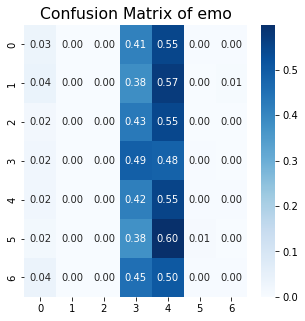

In [20]:
cm_plot(y_real, y_preds)

In [13]:
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_real, y_preds))

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

           0       0.19      0.04      0.06      2848
           1       0.00      0.00      0.00       644
           2       0.00      0.00      0.00       458
           3       0.18      0.49      0.26      3145
           4       0.47      0.55      0.51      9437
           5       0.21      0.01      0.02      1886
           6       0.10      0.00      0.01      1908

    accuracy                           0.34     20326
   macro avg       0.16      0.16      0.12     20326
weighted avg       0.30      0.34      0.29     20326



C:\Users\Kate\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Kate\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Kate\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif